$V(x,y) = \frac{1}{2}\left(x^2+y^2\right) + \left(x^2y-\frac{y^3}{3}\right)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pImpactR.util import naff 
from copy import deepcopy as copy
ny = 128
npy = 128
radi2 = 10
npt = ny*npy
NTURN = [128,256,512,1024,2048]
nsteps = 1000
dt = 1.0e-3

In [2]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [3]:
def drift(x,px,y,py,dt):
    x = x + px*dt
    y = y + py*dt
    return x,y

def kick(x,px,y,py,dt):
    px = px - dt*(x +2*x*y)
    py = py - dt*(y +  x*x  -y*y)
    return px,py
    
def oneStep(x,px,y,py,dt):
    x,y = drift(x,px,y,py,0.5*dt)
    px,py = kick (x,px,y,py,    dt)
    x,y = drift(x,px,y,py,0.5*dt)
    return x,px,y,py

def multiStep(x,px,y,py,dt,nsteps):
    x,y = drift(x,px,y,py,0.5*dt)
    for i in range(nsteps-1):
        px,py = kick (x,px,y,py,dt)
        x,y   = drift(x,px,y,py,dt)
    px,py = kick (x,px,y,py,dt)
    x,y   = drift(x,px,y,py,0.5*dt)
    return x,px,y,py

In [4]:
def Init(energy):
    y = []
    py= []
    px= []
    i=0
    for y0 in np.linspace(-0.5,0.8,ny):
        for py0 in np.linspace(-0.5,0.5,npy):
            px2 = 2*energy - py0*py0 - y0*y0 + 2.0/3.0*y0**3
            if px2 >= 0.0:
                y.append(y0)
                py.append(py0)
                px.append(np.sqrt(px2))
                
    npt = len(y)
    print(npt)
    x =np.zeros(npt)
    y =np.array(y)
    px=np.array(px)
    py=np.array(py)
                
    return x,px,y,py

In [5]:
def runFoward(x,px,y,py,nturn):
    ilive = x*x+y*y < radi2
    npt = len(y)
    data = np.zeros([nturn,npt,4])
    data[0,:,0] = x[:]
    data[0,:,1] = px[:]
    data[0,:,2] = y[:]
    data[0,:,3] = py[:]
    for i in range(1,nturn):
        x,px,y,py = multiStep(x,px,y,py,dt,nsteps)
        ilive = np.logical_and(ilive,x*x+y*y < radi2)
        data[i,:,0] = x
        data[i,:,1] = px
        data[i,:,2] = y
        data[i,:,3] = py
    return data[:,ilive,:]

In [6]:
def runBackward(x,px,y,py,nturn):
    npt = len(y)
    data = np.zeros([nturn,npt,4])
    for i in range(nturn):
        x,px,y,py = multiStep(x,px,y,py,-dt,nsteps)
        data[i,:,0] = x
        data[i,:,1] = px
        data[i,:,2] = y
        data[i,:,3] = py
    return data

In [7]:
def runFB(energy,y,py,dt,nturn):
    px2 = 2*energy - py*py - y*y + 2.0/3.0*y**3
    if px2 < 0.0:
        raise ValueError('px*px<0')
        return 0
    px = np.sqrt(px2)
    x = 0.0
    
    tmp = np.zeros([nturn,4])
    data = np.zeros([nturn])
    for i in range(nturn):
        tmp[i,0] = x
        tmp[i,1] =px
        tmp[i,2] = y
        tmp[i,3] =py
        x,px,y,py = multiStep(x,px,y,py,dt,nsteps)  
    for iturn in range(1,nturn):
        x = tmp[iturn,0]
        px= tmp[iturn,1]
        y = tmp[iturn,2]
        py= tmp[iturn,3]
        for jturn in range(iturn):
            x,px,y,py = multiStep(x,px,y,py,-dt,nsteps)
        data[iturn] = np.sqrt( (x -tmp[0,0])**2
                              +(y -tmp[0,2])**2
                              +(px-tmp[0,1])**2
                              +(py-tmp[0,3])**2 )

        
    return data

In [8]:
def getDiff(energy,dt,nturn):
    x,px,y,py = Init(energy)
    dataF = runFoward  (x,px,y,py,2*nturn) 
    x = dataF[nturn,:,0]
    px= dataF[nturn,:,1]
    y = dataF[nturn,:,2]
    py= dataF[nturn,:,3]
    dataB = runBackward(x,px,y,py,  nturn)
    
    dummy,npt,dummy = dataF.shape
    X = dataF[:,:,0] - 1j*dataF[:,:,1]
    Y = dataF[:,:,2] - 1j*dataF[:,:,3]
    tuneXbefore = np.zeros(npt)
    tuneYbefore = np.zeros(npt)
    Xdiff = np.zeros(npt)
    Ydiff = np.zeros(npt)
    for i in range(npt):
        signal = X[:nturn,i] -np.mean(X[:nturn,i])
        tuneXbefore[i],amp,dummy = naff(1,signal,window_id=1)
        signal = X[nturn:,i] -np.mean(X[nturn:,i])
        tune,amp,dummy = naff(5,signal,window_id=1)
        Xdiff[i] = getClosestDiff(tuneXbefore[i],tune)

        signal = Y[:nturn,i] -np.mean(Y[:nturn,i])
        tuneYbefore[i],amp,dummy = naff(1,signal,window_id=1)
        signal = Y[nturn:,i] -np.mean(Y[nturn:,i])
        tune,amp,dummy = naff(5,signal,window_id=1)
        Ydiff[i] = getClosestDiff(tuneYbefore[i],tune)

    cFMA = np.log10(np.sqrt(Xdiff**2 +Ydiff**2)+1.0e-6)
    cFB  = np.log10(np.sqrt(np.sum( (dataF[0,:,:]-dataB[-1,:,:])**2, axis=1)))
    
    return {'y':dataF[0,:,2],'py':dataF[0,:,3],'cFMA':cFMA,'cFB':cFB}

In [ ]:
data = {}
for nturn in NTURN:
    tmp = getDiff(1.0/12.0,dt,nturn)
    data['E=1/12.nturn='+str(nturn)]=copy(tmp)
    
for nturn in NTURN:
    tmp = getDiff(1.0/9.0,dt,nturn)
    data['E=1/9.nturn='+str(nturn)]=copy(tmp)

6772
6772
6772
6772
6772
9220
9220


In [10]:
data.keys()

dict_keys(['E=1/12.nturn=128', 'E=1/12.nturn=256', 'E=1/12.nturn=512', 'E=1/12.nturn=1024', 'E=1/12.nturn=2048', 'E=1/9.nturn=128', 'E=1/9.nturn=256', 'E=1/9.nturn=512', 'E=1/9.nturn=1024', 'E=1/9.nturn=2048'])

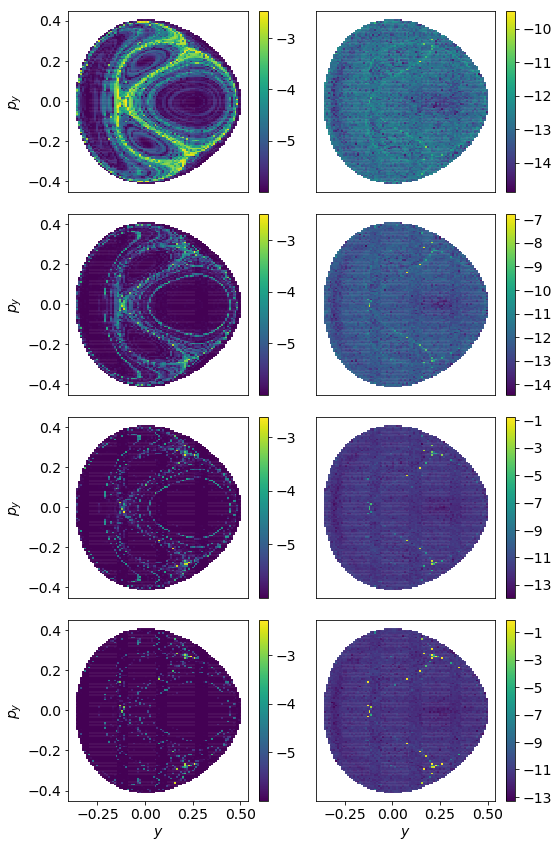

In [30]:
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[8,3*4])
i=1
for nturn in NTURN[1:]:
    tmp = data['E=1/12.nturn='+str(nturn)]
    plt.subplot(4,2,i)
    i=i+1
    f1=plt.scatter(tmp['y'],tmp['py'],c=tmp['cFMA'],s=1.6,marker='s')
    plt.ylabel('$p_y$')
    plt.colorbar(f1, ticks=[-7,-6,-5,-4,-3,-2,-1])
    if i<8:
        plt.xticks([])
    else:
        plt.xlabel('$y$')
    plt.subplot(4,2,i)
    i=i+1
    f1=plt.scatter(tmp['y'],tmp['py'],c=tmp['cFB'],s=1.6,marker='s')
    plt.yticks([])
    if i<8:
        plt.xticks([])
    else:
        plt.xlabel('$y$')
    if i < 6:
        plt.colorbar(f1, ticks=[-15,-14,-13,-12,-11,-10,-9,-8,-7,-5,-3,-1])
    else:
        plt.colorbar(f1, ticks=[-15,-13,-11,-9,-7,-5,-3,-1])
plt.tight_layout()   
plt.savefig('HH_DA_12.overT.png',dpi=160)
plt.savefig('HH_DA_12.overT.eps',dpi=160)

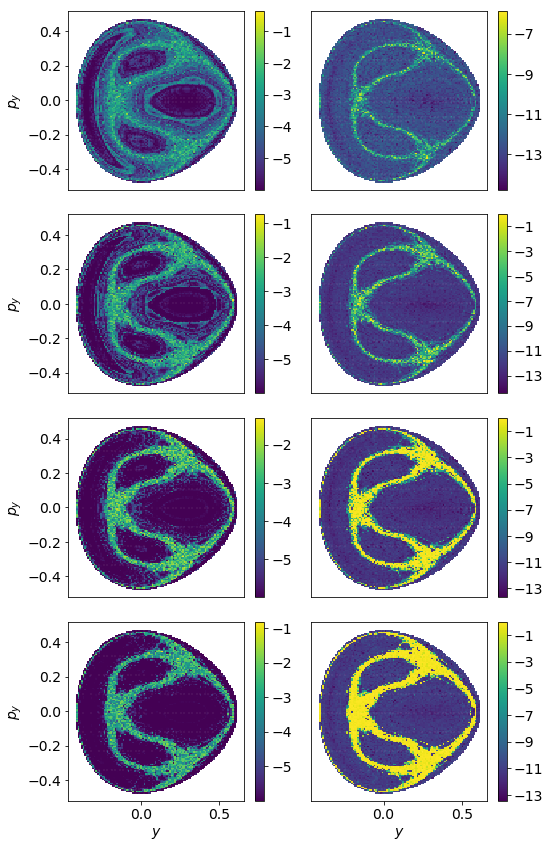

In [32]:
fig = plt.figure(figsize=[8,3*4])
i=1
for nturn in NTURN[1:]:
    tmp = data['E=1/9.nturn='+str(nturn)]
    plt.subplot(4,2,i)
    i=i+1
    f1=plt.scatter(tmp['y'],tmp['py'],c=tmp['cFMA'],s=1.6,marker='s')
    plt.ylabel('$p_y$')
    if i<8:
        plt.xticks([])
    else:
        plt.xlabel('$y$')
    plt.colorbar(f1, ticks=[-7,-6,-5,-4,-3,-2,-1])
    plt.subplot(4,2,i)
    i=i+1
    f1=plt.scatter(tmp['y'],tmp['py'],c=tmp['cFB'],s=1.6,marker='s')
    if i<8:
        plt.xticks([])
    else:
        plt.xlabel('$y$')
    plt.yticks([])
    plt.colorbar(f1, ticks=[-15,-13,-11,-9,-7,-5,-3,-1])
plt.tight_layout()   
plt.savefig('HH_DA_9.overT.png',dpi=160)
plt.savefig('HH_DA_9.overT.eps',dpi=160)